In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import lightgbm as lgb  # Changed to standard lightgbm import
from sklearn.metrics import roc_auc_score
import gc
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    auc as sk_auc
)

# Configuration
RANDOM_STATE = 42
N_COMPONENTS = 20
N_CLUSTERS = 8
CONTAMINATION = 0.01
DATA_PATH = './data/'  # Update with your data path

def load_data():
    """Load transaction and identity data"""
    transactions = pd.read_csv(os.path.join(DATA_PATH, '/kaggle/input/ieee-fraud-detection/train_transaction.csv'), index_col='TransactionID')
    identity = pd.read_csv(os.path.join(DATA_PATH, '/kaggle/input/ieee-fraud-detection/train_identity.csv'), index_col='TransactionID')
    print(f"Transactions shape: {transactions.shape}, Identity shape: {identity.shape}")
    return transactions, identity

def preprocess(transactions, identity):
    """Merge and preprocess data"""
    df = transactions.join(identity, how='left')
    print(f"Merged DataFrame shape: {df.shape}")
    
    # Handle missing values
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col].fillna(df[col].median(), inplace=True)
        elif df[col].dtype == 'object':
            df[col].fillna('unknown', inplace=True)
    
    # Encode categoricals
    for col in df.select_dtypes('object').columns:
        if df[col].nunique() < 1000:  # Avoid high-cardinality
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
        else:
            df.drop(col, axis=1, inplace=True)
    
    # Time-based sorting
    if 'TransactionDT' in df.columns:
        df = df.sort_values('TransactionDT')
    else:
        print("Warning: TransactionDT column not found")
    return df

def create_unsupervised_features(df):
    """Generate features using unsupervised methods"""
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if 'isFraud' in numeric_cols:
        numeric_cols = numeric_cols.drop('isFraud')
    
    if len(numeric_cols) == 0:
        return df
    
    features = df[numeric_cols].fillna(0)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # PCA
    n_components = min(N_COMPONENTS, len(numeric_cols))
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    pca_features = pca.fit_transform(scaled_features)
    pca_cols = [f'PCA_{i}' for i in range(n_components)]
    df_pca = pd.DataFrame(pca_features, columns=pca_cols, index=df.index)
    
    # KMeans
    n_clusters = min(N_CLUSTERS, len(df)//10)
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init='auto')
    df['Cluster'] = kmeans.fit_predict(scaled_features)
    
    # Isolation Forest
    iso = IsolationForest(contamination=CONTAMINATION, random_state=RANDOM_STATE, n_estimators=100)
    df['Anomaly_Score'] = iso.fit_predict(scaled_features)
    
    return pd.concat([df, df_pca], axis=1)

# Main execution
if __name__ == "__main__":
    # Load and preprocess
    transactions, identity = load_data()
    df = preprocess(transactions, identity)
    
    if 'isFraud' not in df.columns:
        raise KeyError("Missing target column 'isFraud'")
    
    # Feature engineering
    df = create_unsupervised_features(df)
    print(f"Data shape after engineering: {df.shape}")
    
    # Train-test split
    X = df.drop('isFraud', axis=1)
    y = df['isFraud']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False, random_state=RANDOM_STATE
    )
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    # Memory cleanup
    del transactions, identity, df
    gc.collect()
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Model parameters
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 128,
        'learning_rate': 0.05,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'is_unbalance': True  # Handles class imbalance
    }
    
    # Train with early stopping using callbacks
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1500,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=50)
        ]
    )
    
   # Evaluate
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    auc_score = roc_auc_score(y_test, y_pred)

    # --- PRC / AP / PR-AUC ---
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    ap_score   = average_precision_score(y_test, y_pred)      # standard single-number summary for PR
    pr_auc     = sk_auc(recall, precision)                    # area under the PR curve (optional, informative)

    print(f"\nTest ROC-AUC: {auc_score:.5f}")
    print(f"Average Precision (AP): {ap_score:.5f}")
    print(f"PR-AUC (area under PR curve): {pr_auc:.5f}")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6, 5))
    plt.step(recall, precision, where="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve (AP={ap_score:.4f})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("precision_recall_curve.png", dpi=150)
    plt.close()

    # Feature importance (gain)
    feat_names = model.feature_name()
    gains = model.feature_importance(importance_type='gain')
    importance = pd.DataFrame({
        'Feature': feat_names,
        'Importance': gains
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Features:")
    print(importance.head(10))

    # Horizontal bar chart for Top 10
    top10 = importance.head(10).iloc[::-1]  # reverse so the biggest is on top
    plt.figure(figsize=(8, 5))
    plt.barh(top10['Feature'], top10['Importance'])
    plt.xlabel("Gain Importance")
    plt.title("Top 10 Features (LightGBM)")
    plt.tight_layout()
    plt.savefig("top10_feature_importance.png", dpi=150)
    plt.close()

    # (Optional) save the full table
    importance.to_csv("feature_importance_gain.csv", index=False)

Transactions shape: (590540, 393), Identity shape: (144233, 40)
Merged DataFrame shape: (590540, 433)


/tmp/ipykernel_36/3091374102.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_36/3091374102.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

Data shape after engineering: (590540, 454)
Train shape: (472432, 453), Test shape: (118108, 453)
[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.681156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38959
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.901367
[100]	valid_0's auc: 0.909552
[150]	valid_0's auc: 0.914245
[200]	valid_0's auc: 0.915007
[250]	valid_0's auc: 0.914911
Early stopping, best iteration is:
[196]	valid_0's auc: 0.915117

Test ROC-AUC: 0.91512
Average Precision (AP): 0.52946
PR-AUC (a

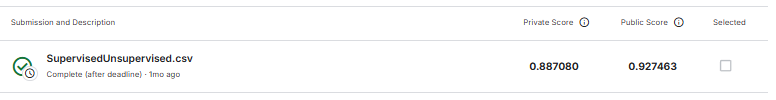

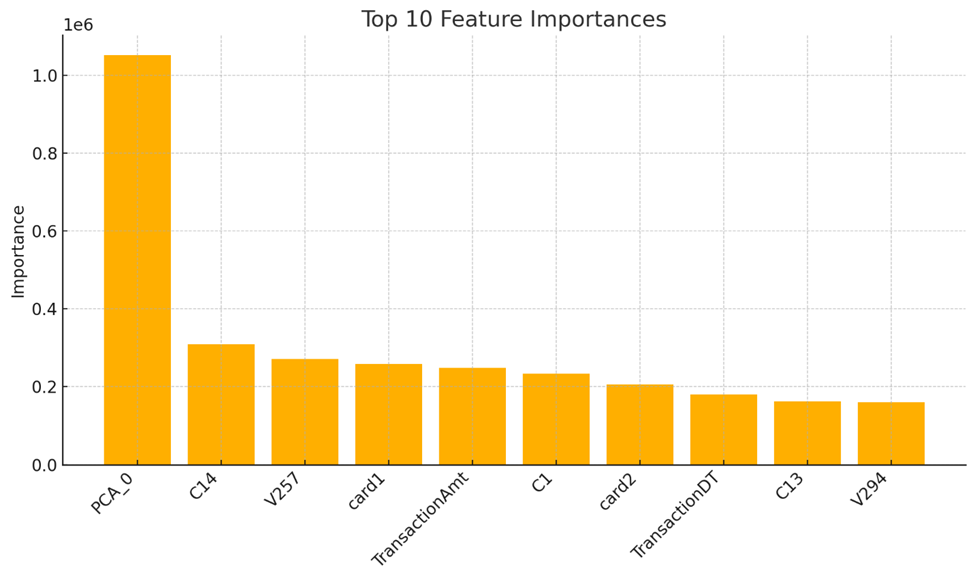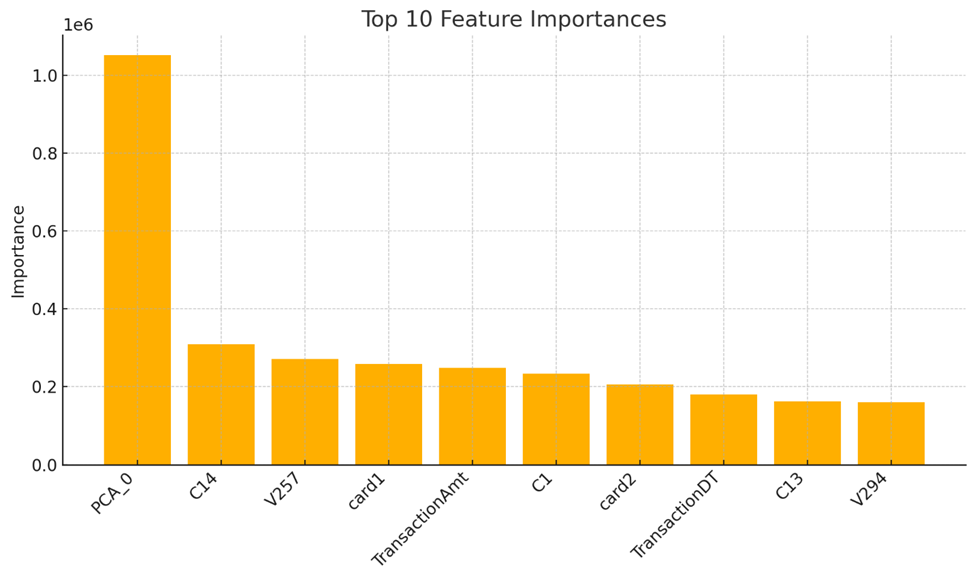